# COVID4HPC - inference test (SW)

This tutorial evaluates the model for Covid-19 detection on several metrics and also shows the regions of attention  on top of Xray images.

## Info
 
- The images used from the dataset for training and testing have 224x224 dimensions.
- The trained model can successfully classify Chest Xray images in 3 classes (COVID-19, NORMAL and Viral Pneumonia).

## Procedure

### Phase 1 
- Dataset pre-processing and load trained model

### Phase 2
- Run inference on test-set and measure time

### Phase 3
- Evaluate model on loss and accuracy
- Show classification report metrics
- Show confusion matrix

### Phase 4
- Generate and visualize saliency maps for our model’s predictions to identify the regions of attention on the Xrays
 (needs tensorflow>=2.0.2)






In [1]:
from __future__ import division
import numpy as np
import os
import sys
import argparse
# Silence TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# workaround for TF1.15 bug "Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from data_preprocess import data_preprocess
from sklearn.metrics import classification_report, confusion_matrix
import time

Using TensorFlow backend.


## Phase 1

In [2]:
# Load dataset images in train and test set
print ('Loading dataset...')
(x_train, y_train), (x_test, y_test) = data_preprocess()
print ('Dataset pre-processed')
    
# Load pretrained model     
model = tf.keras.models.load_model('build/keras_model/CustomCNN.h5')

Loading dataset...
Viral Pneumonia    1345
NORMAL             1341
COVID-19            219
Name: Labels, dtype: int64
Dataset pre-processed


## Phase 2

In [3]:
iterations = 1 # Set how many times to execute inference on test set
total_time = 0
print('Test images: ', len(x_test))
print('Predicting test images for ', iterations , ' iterations on SW')
for i in range (0,iterations):
    start = time.time()
    predictions = model.predict(x_test)
    end = time.time()
    print('Time: ', end - start)
    total_time += (end - start)

# Measure frames/sec performance
print ('\nFPS: ', (iterations*len(x_test))/total_time)

Test images:  727
Predicting test images for  1  iterations on SW
Time:  3.522770881652832

FPS:  206.37163881032828


## Phase 3

In [4]:
# Show loss and accuracy of trained model
scores = model.evaluate(x=x_test,y=y_test,verbose=0)
print('Loss: ', scores[0])
print('Accuracy: ', scores[1])

# Print classification report
rounded_pred = np.argmax(predictions, axis=1)
rounded_label = np.argmax(y_test, axis=1)
print('========================================================')
print(classification_report(rounded_label, rounded_pred.round(), target_names=['COVID-19','NORMAL','Viral Pneumonia'])) 
print('========================================================')

Loss:  0.10907890185959729
Accuracy:  0.97111416
                 precision    recall  f1-score   support

       COVID-19       1.00      0.95      0.97        55
         NORMAL       0.98      0.96      0.97       335
Viral Pneumonia       0.96      0.98      0.97       337

       accuracy                           0.97       727
      macro avg       0.98      0.96      0.97       727
   weighted avg       0.97      0.97      0.97       727



In [5]:
#calculate confusion matrix
cm = confusion_matrix(rounded_label, rounded_pred.round())

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



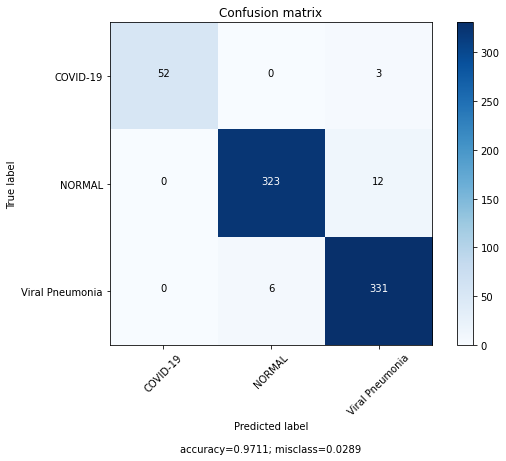

In [6]:
plot_confusion_matrix(cm, target_names=['COVID-19','NORMAL','Viral Pneumonia'])

## Phase 4

In [8]:
from keras import backend as K

from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img


def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss(output):
    # label index of images (0 for 'COVID', 1 for 'NORMAL', 2 for 'Viral Pneumonia')
    return (output[0][0], output[1][0], output[2][1], output[3][1], output[4][2], output[5][2])

# Image titles
image_titles = ['COVID', 'COVID', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'Viral Pneumonia']

# Load images
img1A = load_img("dataset/" + "/COVID-19/COVID-19 (19).png", target_size=(224, 224))
img1B = load_img("dataset/" + "/COVID-19/COVID-19 (10).png", target_size=(224, 224))
img2A = load_img("dataset/" + "/NORMAL/NORMAL (100).png", target_size=(224, 224))
img2B = load_img("dataset/" + "/NORMAL/NORMAL (7).png", target_size=(224, 224))
img3A = load_img("dataset/" + "/Viral Pneumonia/Viral Pneumonia (6).png", target_size=(224, 224))
img3B = load_img("dataset/" + "/Viral Pneumonia/Viral Pneumonia (8).png", target_size=(224, 224))

images = np.asarray([np.array(img1A), np.array(img1B), np.array(img2A), np.array(img2B), np.array(img3A), np.array(img3B)])

# Preparing input data
X = preprocess_input(images)             

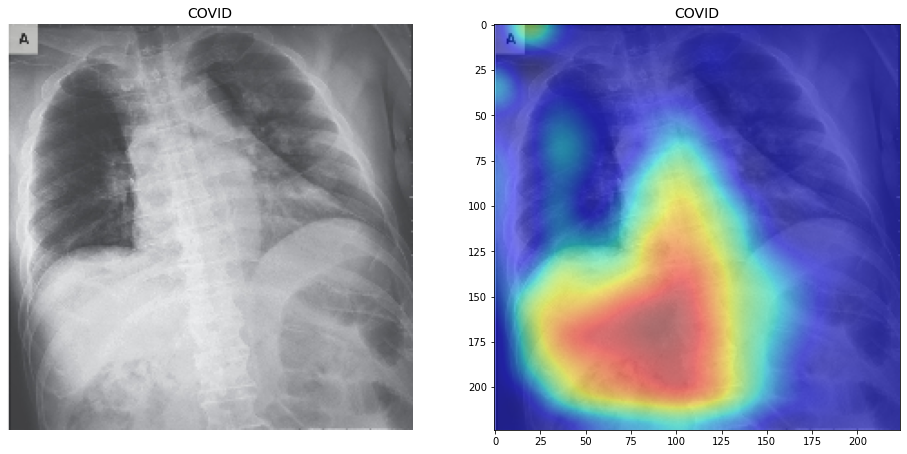

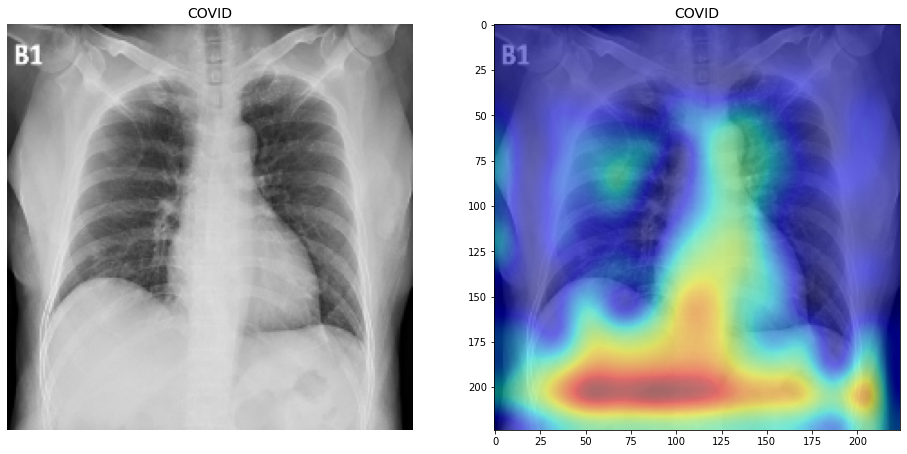

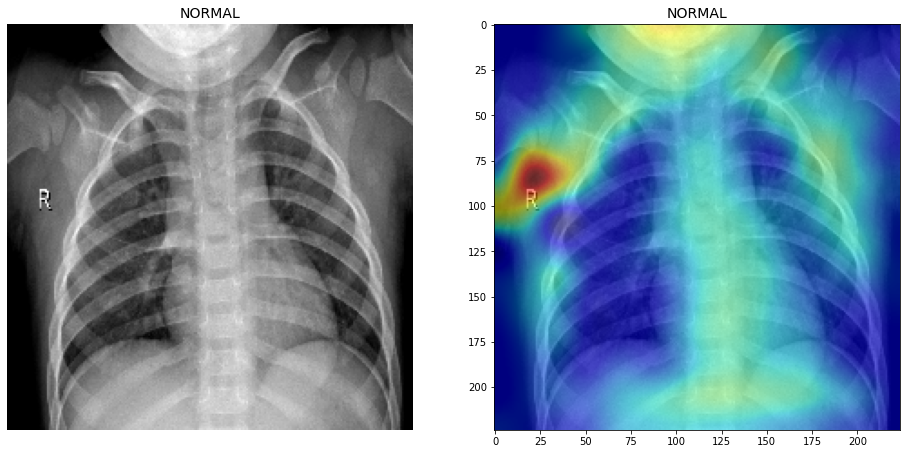

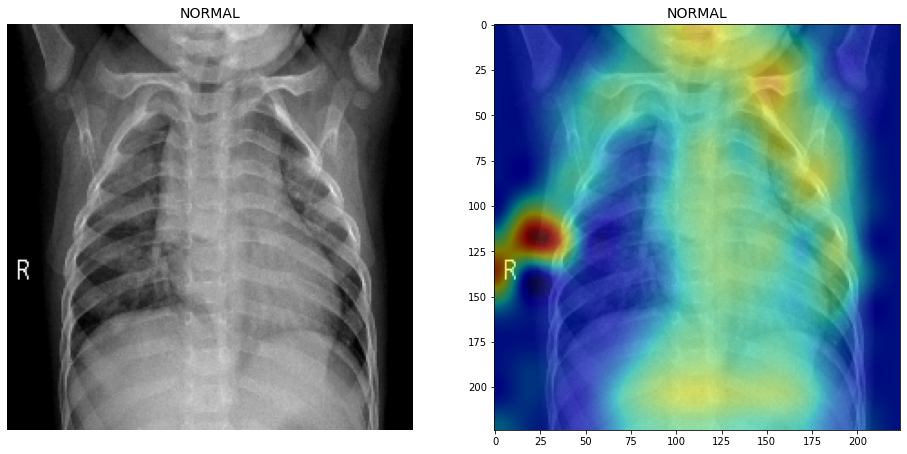

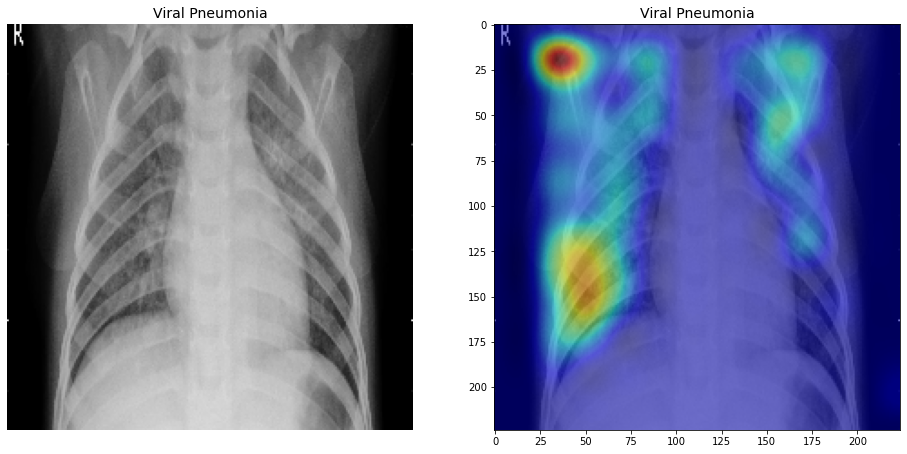

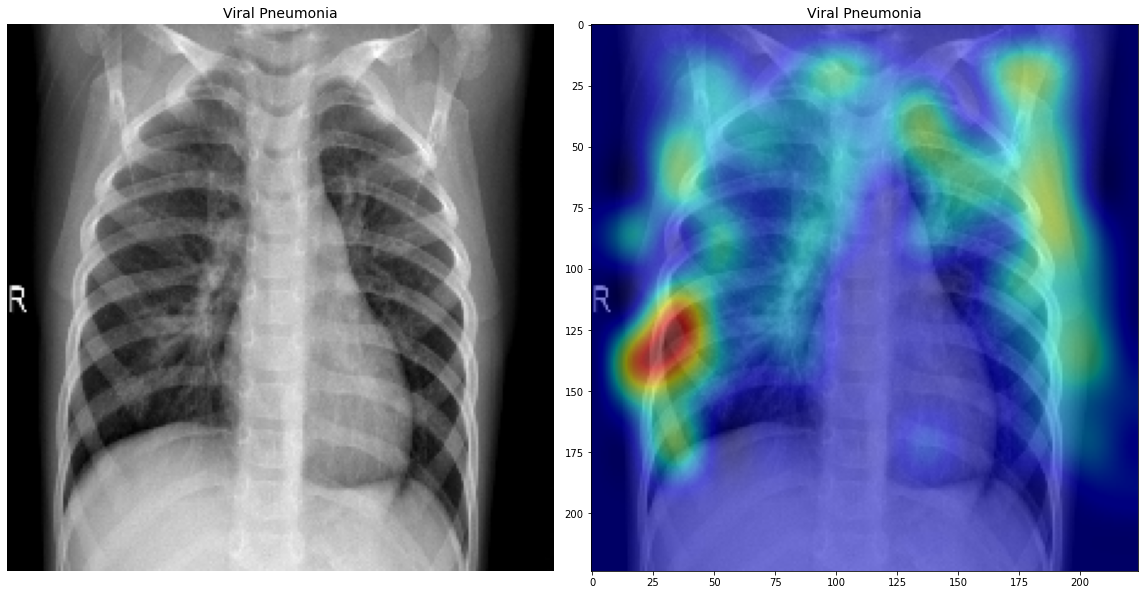

In [9]:
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )

cam = normalize(cam)

for i,title in enumerate(image_titles):
    f,ax = plt.subplots(1,2, figsize=(16,16))
    ax = ax.ravel()
    ax[0].imshow(images[i])
    ax[0].set_title(title, fontsize=14)
    ax[0].axis('off')
    
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[1].set_title(title, fontsize=14)
    ax[1].imshow(images[i])
    ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()